In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cols_demos = [
    'MatchId',
    'MapName' ,
    'WinnerId' ,
    'WinnerScore' ,
    'WinnerFirstHalfScore' ,
    'WinnerSecondHalfScore' ,
    'WinnerFirstHalfSide' ,
    'WinnerOTScore' ,
    'LoserId' ,
    'LoserScore' ,
    'LoserFirstHalfScore' ,
    'LoserSecondHalfScore' ,
    'LoserFirstHalfSide' ,
    'LoserOTScore' ,
    'DemoParsed' ,
    'Created' ,
    'Updated']
cols_map_picks = [
    'MatchId',
    'MapName',
    'DecisionOrder',
    'DecisionTeamId',
    'OtherTeamId',
    'Decision',
    'Created',
    'Updated']
cols_matches = [
    'MatchId',
    'HLTVMatchId',
    'CompetitionId',
    'HLTVLink',
    'MatchType',
    'MatchDate',
    'MatchTime',
    'Stars',
    'Slug',
    'WinnerId',
    'WinnerScore',
    'LoserId',
    'LoserScore',
    'Created',
    'Updated']
cols_teams = [
    'TeamId',
    'HLTVTeamId',
    'HLTVLink',
    'TeamName',
    'Country',
    'Twitter',
    'Facebook',
    'Created',
    'Updated']

data_dir = 'data/'
demos = pd.read_csv(data_dir+'demos.csv',names = cols_demos)
map_picks = pd.read_csv(data_dir+'map_picks.csv',names = cols_map_picks)
matches = pd.read_csv(data_dir+'matches.csv',names = cols_matches)
teams = pd.read_csv(data_dir+'teams.csv',names = cols_teams)

In [3]:
def build_team_record_df(teams,demos):
    '''Creates team_record dataframe where each row is a Team, columns are various stats.
       Inputs are dataframes of the .csvs of the same name.
       Output is a dataframe indexed by teamid'''
    # All team IDs
    team_record = pd.DataFrame(teams['TeamId'].unique().astype(int),columns=['TeamId'])
    # Wins and losses (For games, not matches) by team ID
    game_wins = demos['WinnerId'].value_counts()
    game_losses = demos['LoserId'].value_counts()
    # merge wins and losses 
    team_record = team_record.merge(game_wins,left_on='TeamId',right_index=True,how='left').fillna(0).astype(int)
    team_record = team_record.merge(game_losses,left_on='TeamId',right_index=True,how='left').fillna(0).astype(int)
    team_record.rename(columns={"WinnerId": "GameWins", "LoserId": "GameLosses"},inplace=True)
    team_record['TotalGames'] = team_record['GameWins']+team_record['GameLosses'].astype(int)
    team_record['WinPercent'] = (team_record['GameWins']/team_record['TotalGames']).fillna(0)
    # Set index to team_id, to simplify things
    team_record.set_index('TeamId',drop=False,inplace=True)
    return team_record    

def win_pct_by_map(demos,team_record):
    '''Calculates win percentage by map for teams in team_record 
       and appends win/loss/matches/win_pct columns to team_record.
       demos - the demos dataframe, no alterations
       team_record - output of build_team_record_df, or a filtered version (i.e. removing few-match teams)
       '''
    
    # Count wins and losses by map and by team
    wins = demos.groupby(['WinnerId','MapName']).count()['MatchId']
    losses = demos.groupby(['LoserId','MapName']).count()['MatchId']
    
    # Fills the dataframe with wins and losses, sums for matches, divides for win_pct
    for m in demos['MapName'].unique():
        for t in team_record['TeamId']:
            # Wins
            try:
                team_record.loc[t,m+'_wins'] = wins[(t,m)]
            except KeyError:
                team_record.loc[t,m+'_wins'] = 0
            # Losses
            try:
                team_record.loc[t,m+'_losses'] = losses[(t,m)]
            except KeyError:
                team_record.loc[t,m+'_losses'] = 0
        team_record[m+'_games'] = team_record[m+'_wins'] + team_record[m+'_losses']
        # Map level win percentage
        team_record[m+'_win_pct'] = team_record[m+'_wins'] / team_record[m+'_games']

    return team_record

In [4]:
team_record = build_team_record_df(teams,demos)
team_record = win_pct_by_map(demos,team_record)

### Games played distribution

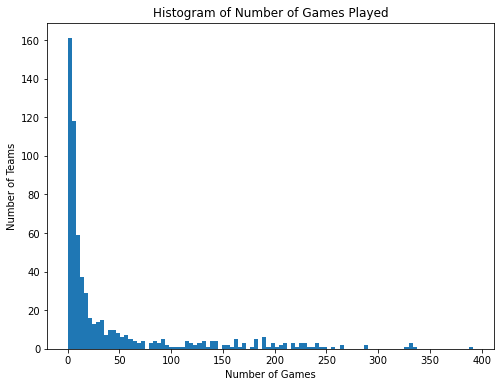

Teams in database:  636
Teams with 0 matches:  10
Teams with 5+ matches:  401
Teams with 10+ matches:  307
Teams with 50+ matches:  139
Teams with 100+ matches:  92
Teams with 200+ matches:  34


In [5]:
plt.figure(figsize=[8,6])
plt.hist(team_record['TotalGames'],bins=100)
plt.title('Histogram of Number of Games Played')
plt.ylabel('Number of Teams')
plt.xlabel('Number of Games')
plt.show()
print("Teams in database: ",team_record.shape[0])
print("Teams with 0 matches: ",(team_record['TotalGames']==0).sum())
print("Teams with 5+ matches: ",(team_record['TotalGames']>5).sum())
print("Teams with 10+ matches: ",(team_record['TotalGames']>10).sum())
print("Teams with 50+ matches: ",(team_record['TotalGames']>50).sum())
print("Teams with 100+ matches: ",(team_record['TotalGames']>100).sum())
print("Teams with 200+ matches: ",(team_record['TotalGames']>200).sum())

### Team win percentage distribution
I've removed teams with fewer than min_matches matches.

In [6]:
# Remove teams with few matches
min_games = 10
team_record = team_record[team_record['TotalGames']>min_games]

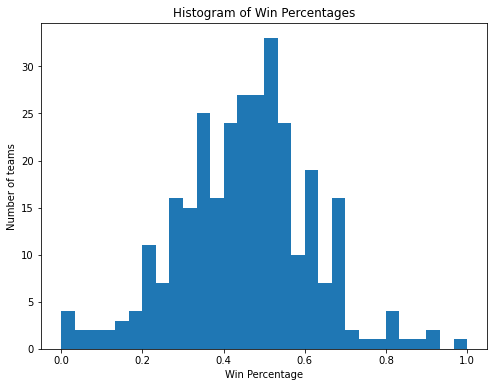

In [7]:
plt.figure(figsize=[8,6])
plt.hist(team_record['WinPercent'],bins=30)
plt.title('Histogram of Win Percentages')
plt.xlabel('Win Percentage')
plt.ylabel('Number of teams')
plt.show()

### Win percentage by team by map - heatmap
I don't know what to do with this information, but it's kinda pretty.

In [8]:
# Win pct columns for the plot
win_cols=['WinPercent']
win_cols.extend([m+'_win_pct' for m in list(demos['MapName'].unique()[:7])])

In [9]:
win_cols

['WinPercent',
 'de_inferno_win_pct',
 'de_nuke_win_pct',
 'de_dust2_win_pct',
 'de_vertigo_win_pct',
 'de_mirage_win_pct',
 'de_train_win_pct',
 'de_overpass_win_pct']

In [10]:
team_record['TeamId']

TeamId
4        4
5        5
6        6
8        8
9        9
      ... 
580    580
583    583
584    584
589    589
594    594
Name: TeamId, Length: 307, dtype: int64

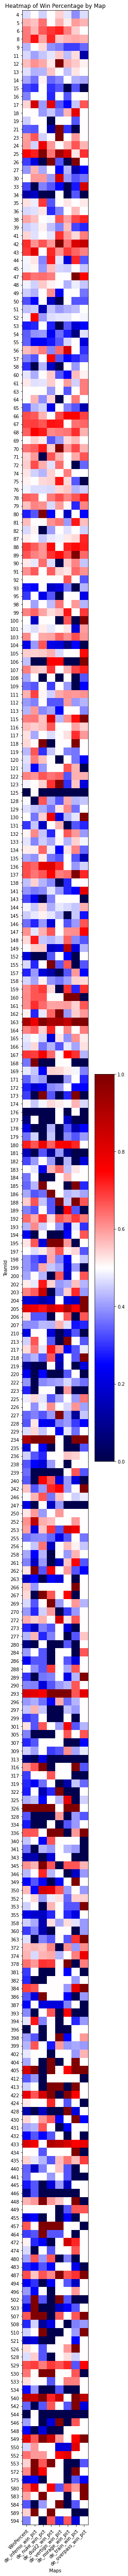

In [11]:
fig,ax = plt.subplots(figsize=[5,100])
im = plt.imshow(team_record[win_cols].fillna(.5),
                cmap='seismic',
                vmin=0,
                vmax=1,
               )
plt.colorbar()
ax.set_xticks(np.arange(len(win_cols)))
ax.set_yticks(np.arange(len(team_record)))
# ... and label them with the respective list entries
ax.set_xticklabels(win_cols)
ax.set_yticklabels(team_record['TeamId'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.title('Heatmap of Win Percentage by Map')
plt.xlabel('Maps')
plt.ylabel('TeamId')
plt.show()

Red: above 50 win%  
White: equal 50 win%  
Blue: below 50 win%  

# Map Selection and Veto percentage by team
I'm just looking at decision_order 1 right now, but change decision_order to look at a different decision. It gets messier though since all maps aren't available then.

In [12]:
decision_order = 1
map_selection_table = pd.pivot_table(map_picks[map_picks['DecisionOrder']==decision_order], 
                                     values='DecisionOrder', index=['DecisionTeamId'],
                                     columns=['MapName'], aggfunc=np.ma.count)

In [13]:
map_selection_table

MapName,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo
DecisionTeamId,,,,,,,
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,NaN,NaN,NaN,NaN
4,14.0,5.0,NaN,3.0,NaN,NaN,3.0
5,48.0,NaN,NaN,NaN,NaN,1.0,NaN
6,1.0,7.0,1.0,1.0,63.0,2.0,9.0
...,...,...,...,...,...,...,...
632,NaN,NaN,1.0,NaN,NaN,NaN,NaN
633,NaN,NaN,NaN,NaN,1.0,NaN,NaN
635,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [14]:
map_selection_table = map_selection_table.fillna(0).astype(int)
total_first_picks = map_selection_table.sum(axis=1)
map_selection_table['total_first_picks'] = total_first_picks

In [15]:
# % of the time each team vetoes each map with decision 1
decision1_removes = map_selection_table.sort_values(by='total_first_picks',axis=0,ascending=False)
decision1_removes.drop(['total_first_picks'],axis=1).div(decision1_removes['total_first_picks'],axis='index')[:25]

MapName,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo
DecisionTeamId,,,,,,,
51,0.080460,0.000000,0.034483,0.758621,0.022989,0.011494,0.091954
6,0.011905,0.083333,0.011905,0.011905,0.750000,0.023810,0.107143
91,0.012346,0.000000,0.061728,0.765432,0.098765,0.061728,0.000000
38,0.025000,0.012500,0.062500,0.187500,0.000000,0.000000,0.712500
202,0.000000,0.000000,0.088608,0.050633,0.822785,0.000000,0.037975
12,0.012821,0.000000,0.000000,0.000000,0.230769,0.025641,0.730769
122,0.000000,0.013158,0.868421,0.000000,0.052632,0.052632,0.013158
79,0.054054,0.013514,0.027027,0.000000,0.013514,0.783784,0.108108
133,0.153846,0.323077,0.507692,0.000000,0.000000,0.000000,0.015385


In [16]:
# How often to teams veto their favorite map? Calculated as .max(axis=0) of the above table
decision1_removes.drop(['total_first_picks'],axis=1).div(decision1_removes['total_first_picks'],axis='index').max(axis=1)[:25]

DecisionTeamId
51     0.758621
6      0.750000
91     0.765432
38     0.712500
202    0.822785
12     0.730769
122    0.868421
79     0.783784
133    0.507692
45     0.714286
111    0.396552
103    0.965517
9      0.421053
169    0.543860
87     0.803571
52     0.392857
11     0.672727
129    0.703704
76     0.703704
54     0.307692
43     0.980769
174    0.921569
352    0.660000
72     0.860000
107    0.918367
dtype: float64

In [17]:
# Mean of the Series above - how often the average team vetoes their favorite map in Decision 1
decision1_removes.drop(['total_first_picks'],axis=1).div(decision1_removes['total_first_picks'],axis='index').max(axis=1).mean()

0.7702237799392645